# Retail Dataset Analysis

__Introduction:__
> This project focuses on the __[Online Retail II dataset](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci/data)__ from Kaggle, which contains retail transaction records from <br>
> a UK-based online retailer. The primary aim is to analyze the sales data to gain insights into customer <br>
> purchasing behavior and preferences. Predictive model will also be built to forecast customer preferences. <br>

## Preparations

#### Import Libraries And Dataset

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math
import random
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# Import Dataset
df = pd.read_csv("online_retail_II.csv")

#### Useful Functions

In [3]:
def plot_top10_with_description(summary, column_sort, column_aggregate, ylabel, title, ascending=False):
    tmp_ = summary.sort_values(by=column_aggregate, ascending=ascending)[:10]
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].bar(x=tmp_[column_sort], height=tmp_[column_aggregate])
    for label in ax[0].get_xticklabels():
        label.set_rotation(-45)
    ax[0].set_xlabel(column_sort)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)

    ax[1].axis('tight')
    ax[1].axis('off')
    table = ax[1].table(cellText=tmp_[[column_sort, 'Description']].values, colLabels=[column_sort, 'Description'], loc='center')

    for i in range(2):
        table.auto_set_column_width(i)

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)

    plt.tight_layout()
    plt.show()
    del tmp_

In [4]:
def filtered_mean(x, n_sd=2):
    t = np.array(x)
    mu = t.mean()
    sd = t.std()
    filtered_x = t[(t>=mu-sd*n_sd) & (t<=mu+sd*n_sd)]
    return filtered_x.mean()

## Data Pre-Processing

In [5]:
df.sample(5, random_state=1)            # print 5 sample rows of the dataset

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
416846,529196,85132B,CHARLIE AND LOLA TABLE TINS,1,2010-10-27 08:36:00,9.95,12537.0,Sweden
660775,547891,22029,SPACEBOY BIRTHDAY CARD,12,2011-03-28 10:14:00,0.42,13266.0,United Kingdom
703947,552232,23156,SET OF 5 MINI GROCERY MAGNETS,1,2011-05-06 15:54:00,4.13,NaN,United Kingdom
673555,549169,21034,REX CASH+CARRY JUMBO SHOPPER,3,2011-04-06 17:25:00,0.95,17906.0,United Kingdom
376048,525733,21035,SET/2 RED RETROSPOT TEA TOWELS,2,2010-10-06 16:17:00,2.95,17006.0,United Kingdom


We can see that the dataset consists of 8 columns. Notice that Customer ID of the 3rd sample is NaN, indicating that there exist NaN values in the dataset.

In [6]:
df.info()          # general info of columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


We can see that Description and Customer ID contain NaN values. For simplicity, we just remove them.

In [7]:
df = df.dropna(ignore_index=True)
df['Customer ID'] = df['Customer ID'].apply(round)        # Round Customer ID to integer (remove floating points)
df['Customer ID'] = df['Customer ID'].astype(str)        # change datatype of Customer ID to string 

Next, we can check the range of Quantity and Price

In [8]:
df.describe()

,Quantity,Price
count,824364.000000,824364.000000
mean,12.414574,3.676800
std,188.976099,70.241388
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Something interesting about the figures:
1. some quantities are below 0 
2. some prices are equal to 0

we may want to take a look at these records

In [9]:
df[df['Quantity']<=0].sample(5, random_state=1234)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
151145,C508186,21239,PINK SPOTTY CUP,-1,2010-05-13 12:52:00,0.72,17511,United Kingdom
823545,C581465,23660,HENRIETTA HEN MUG,-2,2011-12-08 18:59:00,1.65,15755,United Kingdom
56429,C496630,22244,"HOOK, 3 HANGER ,MAGIC GARDEN",-12,2010-02-03 10:35:00,1.95,12647,Germany
748138,C574503,22178,VICTORIAN GLASS HANGING T-LIGHT,-1,2011-11-04 13:19:00,1.95,16191,United Kingdom
530195,C550475,20718,RED RETROSPOT SHOPPER BAG,-1,2011-04-18 13:59:00,1.06,13798,United Kingdom


The descriptions of these records are normal products, perhaps these are refund records.

In [10]:
df[df['Price']==0].sample(5, random_state=1234)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
619607,561669,22960,JAM MAKING SET WITH JARS,11,2011-07-28 17:09:00,0.0,12507,Spain
747428,574469,22385,JUMBO BAG SPACEBOY DESIGN,12,2011-11-04 11:55:00,0.0,12431,Australia
622161,561916,M,Manual,1,2011-08-01 11:44:00,0.0,15581,United Kingdom
646895,564651,22955,36 FOIL STAR CAKE CASES,144,2011-08-26 14:19:00,0.0,14646,Netherlands
29570,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.0,18071,United Kingdom


Perhaps the records with Price == 0 are giveaways. <br>
Notice that the 3rd sample's StockCode is not numeric and the Description writes "Manual", <br>
We may want to take a look at the records with non-numerical StockCode.

In [11]:
df[df['StockCode'].apply(lambda x: str.isalpha(x))].sample(5, random_state=1234)      # find all non-numerical StockCode

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
415032,537818,POST,POSTAGE,6,2010-12-08 13:53:00,28.0,12766,Portugal
621771,561898,POST,POSTAGE,7,2011-07-31 15:25:00,40.0,12456,Switzerland
51249,C496009,D,Discount,-1,2010-01-28 12:41:00,28.5,17841,United Kingdom
727190,572344,M,Manual,48,2011-10-24 10:43:00,1.5,14607,United Kingdom
293875,525071,POST,POSTAGE,2,2010-10-03 14:50:00,18.0,12583,France


The Description of these records are "POSTAGE", "Discount" and "Manual", which are not usual purchasing records. <br>
Notice that the Invoice of the 3rd sample is not numerical. We may want to take at these cases later.<br><br>
In the next step, we want to see a list of all Description of records with StockCode consist of alphabets only or alphabets and digits

In [12]:
# unique Description of records with StockCode consist of alphabets and digits
df[['StockCode', 'Description']][df['StockCode'].apply(lambda x: not str.isnumeric(x))].drop_duplicates().sort_values('StockCode').head(10)

,StockCode,Description
8679,10123C,HEARTS WRAPPING TAPE
213999,10123G,ARMY CAMO WRAPPING TAPE
97201,10124A,SPOTS ON RED BOOKCOVER TAPE
157061,10124G,ARMY CAMO BOOKCOVER TAPE
11725,15044A,PINK PAPER PARASOL
2249,15044B,BLUE PAPER PARASOL
22440,15044C,PURPLE PAPER PARASOL
2250,15044D,RED PAPER PARASOL
607,15056BL,EDWARDIAN PARASOL BLACK
608,15056N,EDWARDIAN PARASOL NATURAL


The alphabet at the end of the StockCode indicates the variations of a product. <br><br>
Also check the StockCode begining with alphabets:

In [13]:
# unique Description of records with StockCode consist begin alphabets
df[['StockCode', 'Description']][df['StockCode'].apply(lambda x: str.isalpha(x[0]))].drop_duplicates().sort_values('StockCode')

,StockCode,Description
49707,ADJUST,Adjustment by john on 26/01/2010 16
49788,ADJUST,Adjustment by john on 26/01/2010 17
161866,ADJUST,Adjustment by Peter on 24/05/2010 1
194818,ADJUST2,Adjustment by Peter on Jun 25 2010
14239,BANK CHARGES,Bank Charges
111626,BANK CHARGES,Bank Charges
6812,C2,CARRIAGE
648446,CRUK,CRUK Commission
729,D,Discount
648445,DOT,DOTCOM POSTAGE


These are some special transaction types, which are not the main focus of this project.

In [14]:
# records with Invoice consist of alphabets and digits
df[df['Invoice'].apply(lambda x: not str.isnumeric(x))].sample(5, random_state=1234)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
151145,C508186,21239,PINK SPOTTY CUP,-1,2010-05-13 12:52:00,0.72,17511,United Kingdom
823545,C581465,23660,HENRIETTA HEN MUG,-2,2011-12-08 18:59:00,1.65,15755,United Kingdom
56429,C496630,22244,"HOOK, 3 HANGER ,MAGIC GARDEN",-12,2010-02-03 10:35:00,1.95,12647,Germany
748138,C574503,22178,VICTORIAN GLASS HANGING T-LIGHT,-1,2011-11-04 13:19:00,1.95,16191,United Kingdom
530195,C550475,20718,RED RETROSPOT SHOPPER BAG,-1,2011-04-18 13:59:00,1.06,13798,United Kingdom


In [15]:
# a summary of records with Invoice consist of alphabets and digits
df[df['Invoice'].apply(lambda x: not str.isnumeric(x))].describe()

,Quantity,Price
count,18744.000000,18744.000000
mean,-25.970604,23.899851
std,821.040686,424.194716
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


All records with Invoice consist of digits and alphabets have Quantiry <= -1. <br>
They are probably refund cases. 

Let's take a deeper look into the cases with negative Quantity. <br>
We take this record as a sample:

We try to find if this customer has bought a "PINK  SPOTTY CUP" before:

In [16]:
tmp = df[df['Customer ID'] == '17511']
tmp[tmp['Description'] == 'PINK  SPOTTY CUP']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
74130,499009,21239,PINK SPOTTY CUP,96,2010-02-24 11:59:00,0.72,17511,United Kingdom
120474,504498,21239,PINK SPOTTY CUP,96,2010-04-14 11:16:00,0.72,17511,United Kingdom
151145,C508186,21239,PINK SPOTTY CUP,-1,2010-05-13 12:52:00,0.72,17511,United Kingdom
164147,509873,21239,PINK SPOTTY CUP,96,2010-05-26 11:12:00,0.72,17511,United Kingdom


The customer has brought the cups for 3 times. <br>
The refunding happens between the 2nd and 3rd purchases. <br>

Let's look at another case:

In [17]:
tmp = df[df['Customer ID'] == '15755']
tmp[tmp['StockCode'] == '23660']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
803537,579467,23660,HENRIETTA HEN MUG,12,2011-11-29 14:57:00,1.65,15755,United Kingdom
823545,C581465,23660,HENRIETTA HEN MUG,-2,2011-12-08 18:59:00,1.65,15755,United Kingdom


We can almost confirm that the records with negative Quantity are refundings. (Besides those with special StockCode)

The goal of this project is to draw insights in the sales records. <br>
The refunding cases, special transactions and giveaways are not the focus. <br>
The following cases would be excluded: 
1. Quantity <= 0
2. Price <= 0
3. StockCode starts with alphabets
4. NaN (Done)

In [18]:
df = df[df['StockCode'].apply(lambda x: not str.isalpha(x[0]))]       # remove StockCode starts with alphabets
df = df[df['Price'] > 0]                                              # remove Price <= 0

In [19]:
df = df.sort_values(by=['Customer ID', 'StockCode', 'Price', 'Quantity', 'InvoiceDate'],
               ascending=[True, True, True, True, False]).reset_index(drop=True)
df['Accumulated'] = 0

In [20]:
c_c, c_s = '', ''
c_p, accu = 0, 0
for i in tqdm(range(df.shape[0])):
    row_i = df.loc[i]
    is_next = row_i['StockCode'] != c_s or row_i['Customer ID'] != c_c or row_i['Price'] != c_p
    if is_next:
        accu = row_i['Quantity']
        df.loc[i, 'Accumulated'] = row_i['Quantity']
        c_c, c_s = row_i['Customer ID'], row_i['StockCode']
        c_p = row_i['Price']
    else:
        if accu < 0:
            accu += row_i['Quantity']
            df.loc[i, 'Accumulated'] = accu
            #df.loc[i, 'Quantity'] = accu
        else:
            df.loc[i, 'Accumulated'] = row_i['Quantity']

        #df.loc[i, 'Accumulated'] = row_i['Quantity'] + accu
        #accu += row_i['Quantity']

  0%|          | 0/820565 [00:00<?, ?it/s]

In [21]:
df.loc[330:350]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Accumulated
330,C490283,20747,PICCADILLY TEA SET,-1,2009-12-04 12:49:00,14.95,12349,Italy,-1
331,C490283,20914,SET/5 RED SPOTTY LID GLASS BOWLS,-1,2009-12-04 12:49:00,2.95,12349,Italy,-1
332,577609,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,6,2011-11-21 09:51:00,2.95,12349,Italy,5
333,529344,20985,HEART CALCULATOR,12,2010-10-28 08:23:00,1.25,12349,Italy,12
334,577609,21086,SET/6 RED SPOTTY PAPER CUPS,12,2011-11-21 09:51:00,0.65,12349,Italy,12
335,506394,21086,SET/6 RED SPOTTY PAPER CUPS,12,2010-04-29 13:20:00,0.65,12349,Italy,12
336,577609,21136,PAINTED METAL PEARS ASSORTED,16,2011-11-21 09:51:00,1.69,12349,Italy,16
337,506394,21218,RED SPOTTY BISCUIT TIN,6,2010-04-29 13:20:00,3.75,12349,Italy,6
338,C490283,21231,SWEETHEART CERAMIC TRINKET BOX,-1,2009-12-04 12:49:00,1.25,12349,Italy,-1
339,529344,21231,SWEETHEART CERAMIC TRINKET BOX,24,2010-10-28 08:23:00,1.25,12349,Italy,23


In [22]:
df = df[df['Accumulated']>0]
df = df.drop(columns=['Quantity'])
df = df.rename(columns={'Accumulated': 'Quantity'})

For easier investigation, the product of Price and Quantity (TotalPrice) is added as a new column.

In [23]:
df['TotalPrice'] = df['Price'] * df['Quantity']

In [24]:
df.reset_index(drop=True, inplace=True)

## EDA

In this section, we will investigate how price, product type, date and other factors affect customers' preference. 

#### Products related

###### Collaspse

In [25]:
summary = df.groupby(['StockCode', 'Customer ID'])['Quantity'].count().reset_index()
summary = summary.groupby('StockCode')['Customer ID'].count().sort_values(ascending=False).reset_index()
summary.rename(columns={'Customer ID':'# of Customers Purchased'}, inplace=True)

In [26]:
tmp1 = df.groupby('StockCode')['Price'].idxmax().values

In [27]:
summary = pd.merge(summary, df[['StockCode', 'Description']].loc[tmp1], on='StockCode')

######

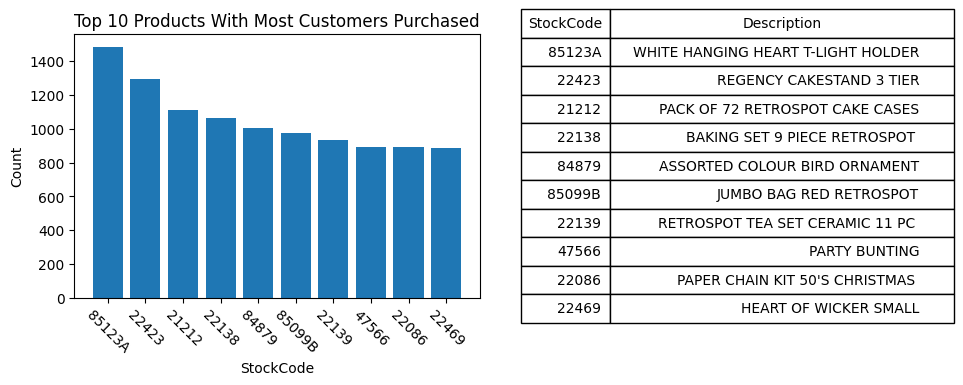

In [28]:
plot_top10_with_description(summary,'StockCode' , '# of Customers Purchased', 'Count', 'Top 10 Products With Most Customers Purchased')

The figure above shows the 10 products with the most customers purchased. <br>
From the list, we can see that most of them are bakery related items or little decorations.

Next, we want to see the items with highest and lowest unit price.

###### Collapse

In [29]:
tmp1 = df.groupby('StockCode')['Price'].max()
summary = pd.merge(summary, tmp1, on='StockCode')
del tmp1

######

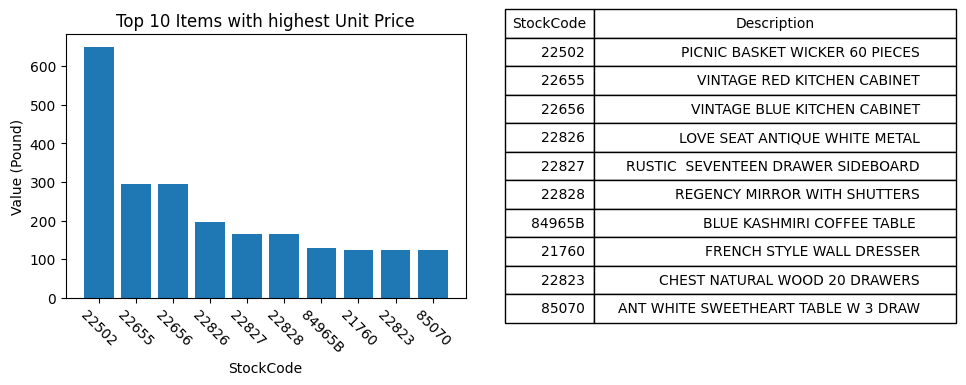

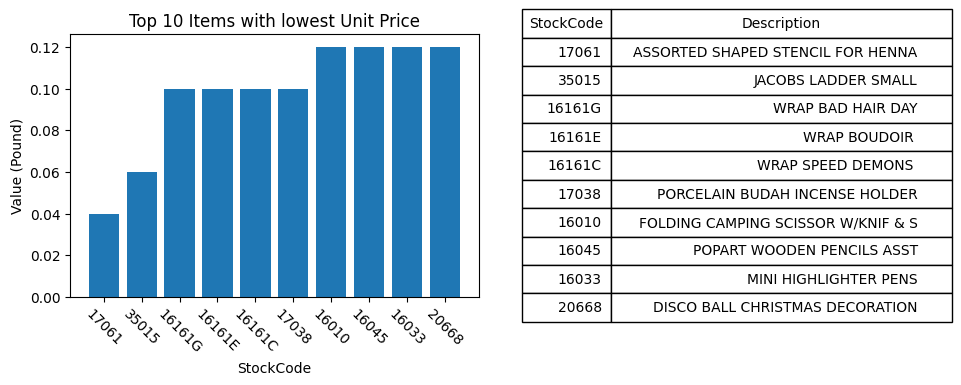

In [30]:
plot_top10_with_description(summary,'StockCode', 'Price', 'Value (Pound)', 'Top 10 Items with highest Unit Price', False)
plot_top10_with_description(summary,'StockCode', 'Price', 'Value (Pound)', 'Top 10 Items with lowest Unit Price', True)

The items with the highest unit prices are mainly large furnitures (with the 1st one being an exception: a set of 60 picnic baskets) <br>
Meanwhile, the items with the lowest unit prices are mainly stationaries or little decorations. 

If we plot log(Quantity) against log(Price):

###### Collapse

In [31]:
tmp1 = df.groupby('StockCode')['Quantity'].sum().reset_index()
tmp1.rename(columns={'Quantity':'Total #'}, inplace=True)
summary = pd.merge(summary, tmp1, on='StockCode')
del tmp1

In [32]:
X = summary['Total #'].apply(math.log).to_numpy().reshape((-1,1))
y = summary['Price'].apply(math.log).to_numpy().reshape((-1,1))
model = LinearRegression()
model.fit(X, y)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


######

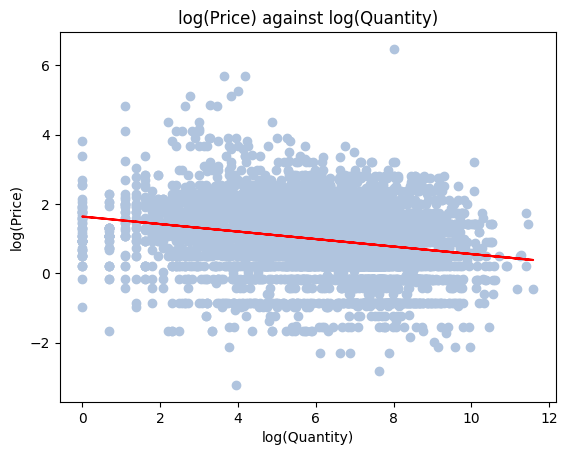

In [33]:
plt.scatter(x=X, y=y, color='lightsteelblue')
plt.plot(X, model.predict(X), color='red')
plt.xlabel('log(Quantity)')
plt.ylabel('log(Price)')
plt.title('log(Price) against log(Quantity)')
plt.show()

In the graph above, each point is the __log max unit price__ vs __log total quantity sold of an item__. <br>
The reason of using log is to scale down some extreme data points. <br><br>

The red line is a regression line of the points. <br>
Its downward slope implies that items with higher unit prices tend to sell less, which matches our intuition.

#### Extreme Cases (Invoices & Transactions)

First, we take a look at the distributions of Total value of each invoice and each transaction. 

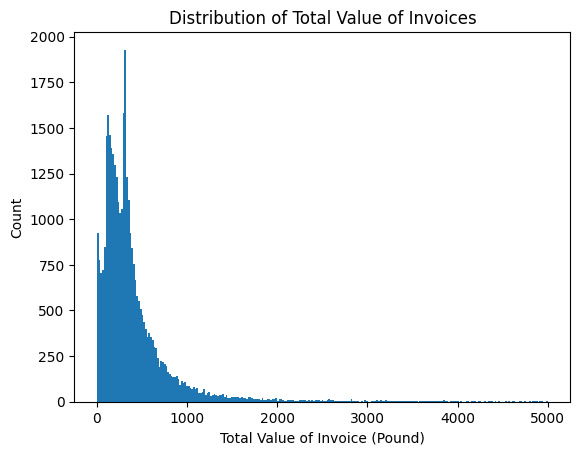

filtered mean: 373.13


In [34]:
tmp = df.groupby('Invoice')['TotalPrice'].sum().reset_index()
plt.hist(tmp['TotalPrice'], bins='auto', range=(0,5000))
plt.ylabel('Count')
plt.xlabel('Total Value of Invoice (Pound)')
plt.title('Distribution of Total Value of Invoices')
plt.show()
print(f"filtered mean: {round(filtered_mean(tmp['TotalPrice']), 2)}")



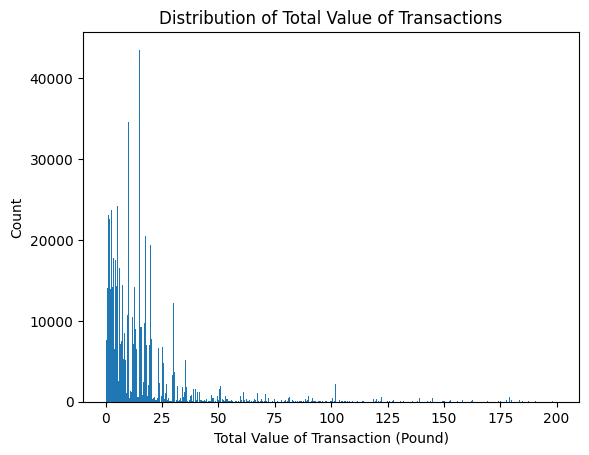

filtered mean: 16.71


In [35]:
plt.hist(df['TotalPrice'], bins='auto', range=(0,200))
plt.ylabel('Count')
plt.xlabel('Total Value of Transaction (Pound)')
plt.title('Distribution of Total Value of Transactions')
plt.show()
print(f"filtered mean: {round(filtered_mean(df['TotalPrice']), 2)}")

The distributions of the graphs above are similar in shapes, (concentrated at smaller values and right-skewed) <br>
with filtered mean of 375.13 (Invoice) and 16.71 (Transaction). <br>
Most Values are below 1000 (Invoice) and 50 (Transaction). <br><br>

Notice that some extreme data points are truncated. We will now take a look at those points:


In [36]:
print("#### Top 10 Transactions With The Highest Total Value ####")
df.sort_values(by='TotalPrice', ascending=False).head(10)

#### Top 10 Transactions With The Highest Total Value ####


,Invoice,StockCode,Description,InvoiceDate,Price,Customer ID,Country,Quantity,TotalPrice
380358,556444,22502,PICNIC BASKET WICKER 60 PIECES,2011-06-10 15:28:00,649.50,15098,United Kingdom,60,38970.00
467859,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,2010-11-04 11:36:00,1.69,15838,United Kingdom,9360,15818.40
765837,511465,15044A,PINK PAPER PARASOL,2010-06-08 12:59:00,2.55,18008,United Kingdom,3500,8925.00
680012,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,2011-09-20 11:05:00,5.06,17450,United Kingdom,1412,7144.72
456237,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,2011-01-11 12:55:00,2.10,15749,United Kingdom,3114,6539.40
467858,525968,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,2010-10-08 10:10:00,1.66,15838,United Kingdom,3120,5179.20
304938,573003,23084,RABBIT NIGHT LIGHT,2011-10-27 12:11:00,2.08,14646,Netherlands,2400,4992.00
456242,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-04-18 13:20:00,2.40,15749,United Kingdom,1930,4632.00
679774,524181,21622,VINTAGE UNION JACK CUSHION COVER,2010-09-27 16:59:00,6.89,17450,United Kingdom,648,4464.72
758363,558526,23173,REGENCY TEAPOT ROSES,2011-06-30 11:01:00,8.15,17949,United Kingdom,540,4401.00


The top record shows the purchase of 60 sets of 60 picnic basket wickers. It’s possible that the quantity <br>
of 60 refers to a set of 60 rather than 60 sets of 60. Unfortunately, we don't have any way to distinguish <br>
between these interpretations, so we will keep this record unchanged. <br>
<br>
The next 2-3 records involve the purchase of 9,360 light holders and 3,500 paper parasols, respectively. <br>
Although the unit prices of these items are not high, <br>
the large quantities purchased result in a significantly high total price. <br>

In [37]:
print("#### Top 10 Invoices With The Highest Total Value ####")
tmp1 = df.groupby('Invoice')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False)
tmp1.rename(columns={'TotalPrice':'Total Value'}, inplace=True)
tmp2 = df.groupby('Invoice')['TotalPrice'].count().reset_index()
tmp2.rename(columns={'TotalPrice':'# of transactions'}, inplace=True)
pd.merge(tmp1, tmp2, on='Invoice').head(10)

#### Top 10 Invoices With The Highest Total Value ####


,Invoice,Total Value,# of transactions
0,493819,43555.10,93
1,556444,38970.00,1
2,524181,33167.80,13
3,537659,31770.98,18
4,567423,27872.80,11
5,526934,26007.08,15
6,515944,22863.36,17
7,556917,22668.43,138
8,572209,22206.00,7
9,567381,22104.80,12


Most Invoices in the table have a number of transactions greater than 10. However, note that the <br>
second row from the top refers to the picnic basket wickers purchase mentioned in the previous section. <br>
A single transaction accounts for the second highest amount overall. This is an extreme case.

#### Customer Behavior

In [38]:
tmp = df[['Customer ID', 'StockCode']].drop_duplicates()
tmp = tmp.groupby('Customer ID')['StockCode'].count()
print(f"On average, a customer have bought {round(tmp.mean(), 2)} different products")

On average, a customer have bought 81.88 different products


##### Best Customers

Next, we will look at the best customers.

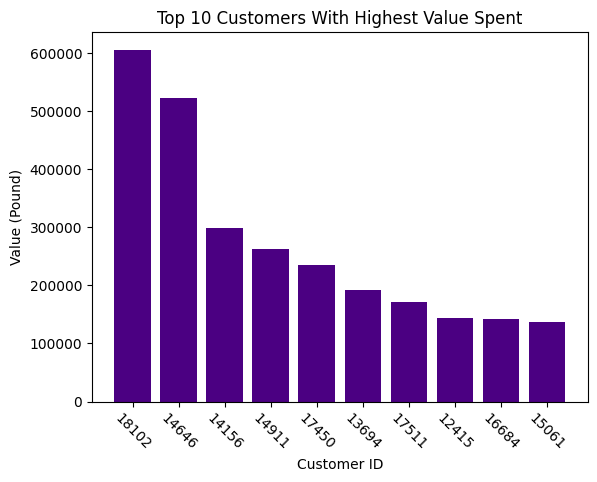

In [39]:
tmp = df.groupby('Customer ID')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False)
tmp.rename(columns={'TotalPrice':'Total Value Spent'}, inplace=True)
plt.bar(x=tmp['Customer ID'][:10], height=tmp['Total Value Spent'][:10], color="indigo")
plt.title('Top 10 Customers With Highest Value Spent')
plt.ylabel('Value (Pound)')
plt.xlabel('Customer ID')
plt.xticks(rotation=-45)
plt.show()

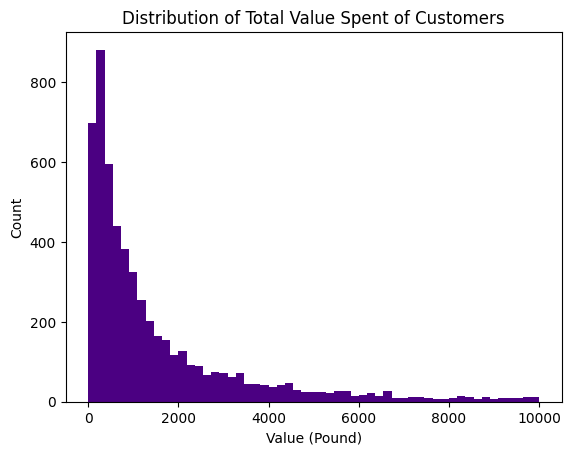

filtered mean: 2033.66


In [40]:
plt.hist(x=tmp['Total Value Spent'], bins='auto', range=(0,10000), color='indigo')
plt.title('Distribution of Total Value Spent of Customers')
plt.ylabel('Count')
plt.xlabel('Value (Pound)')
plt.show()
print(f"filtered mean: {round(filtered_mean(tmp['Total Value Spent']), 2)}")

The filtered mean of all customers' total spending is 2033.66, meanwhile the spending of the top 10 costumers are way high (>100000). <br>


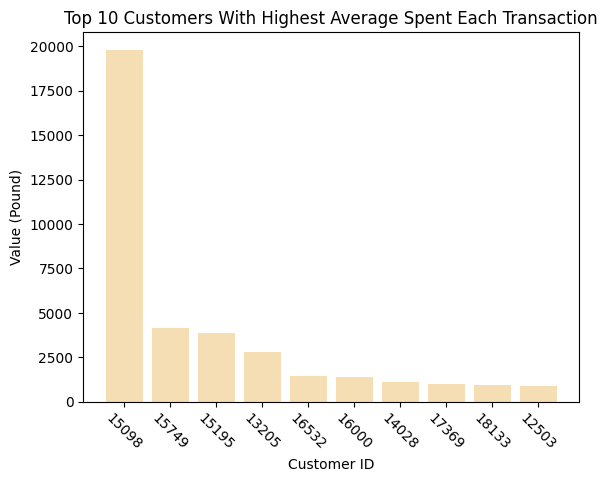

In [41]:
tmp = df.groupby('Customer ID')['TotalPrice'].mean().reset_index().sort_values(by='TotalPrice', ascending=False)
tmp.rename(columns={'TotalPrice':'Average Value Spent Each Transaction'}, inplace=True)
plt.bar(x=tmp['Customer ID'][:10], height=tmp['Average Value Spent Each Transaction'][:10], color="wheat")
plt.title('Top 10 Customers With Highest Average Spent Each Transaction')
plt.ylabel('Value (Pound)')
plt.xlabel('Customer ID')
plt.xticks(rotation=-45)
plt.show()

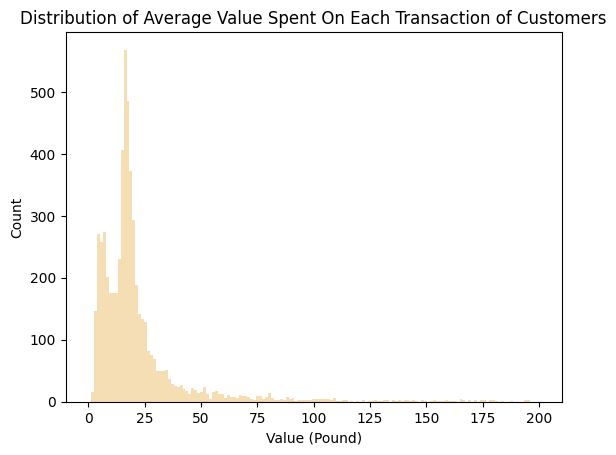

filtered mean: 26.51


In [42]:
plt.hist(x=tmp['Average Value Spent Each Transaction'], bins='auto', range=(0,200), color='wheat')
plt.title('Distribution of Average Value Spent On Each Transaction of Customers')
plt.ylabel('Count')
plt.xlabel('Value (Pound)')
plt.show()
print(f"filtered mean: {round(filtered_mean(tmp['Average Value Spent Each Transaction']), 2)}")

The filtered mean of all customers' Average spending on each transaction is 26.51, meanwhile the spending of the top 2 costumers exceeded 2500. 
<br><br>
From the information above, we know that some customers buy way more than the others.


##### Repeatedly Buying

Next, we will see if customers will buy the same products again

In [43]:
tmp = df[['Customer ID', 'Invoice', 'StockCode']].drop_duplicates()
tmp1 = tmp[tmp[['Customer ID', 'StockCode']].duplicated()]

In [44]:
print(f"Ratio of Customers buying the same items again: {round(len(tmp1['Customer ID'].unique())/len(df['Customer ID'].unique()), 2)}")
print(f"On average, Customers purchase an item {round(tmp.groupby(['Customer ID', 'StockCode'])['Invoice'].count().mean(), 2)} times.")

Ratio of Customers buying the same items again: 0.66
On average, Customers purchase an item 1.59 times.


Around 2/3 of the customers will purchase an item again. <br>
On average, an item would be purchased 1.59 times by the same customer. <br>
From these informations, we know that customers will purchase the same items after their first purchases.

##### Buying Variations

Some products have variances (those StockCode end with alphabet). <br>
We will see if customers would buy the variances after they brought one of them.

###### Collapse

In [45]:
tmp = df[['Invoice', 'StockCode']].copy()
tmp['StockCode_F'] = tmp['StockCode'].apply(lambda x: x[:-1] if str.isalpha(x[-1]) else "-")
tmp['StockCode_L'] = tmp['StockCode'].apply(lambda x: x[-1] if str.isalpha(x[-1]) else "-")

In [46]:
func1 = lambda x: len(x.unique())
tmp = tmp.groupby(['Invoice', 'StockCode_F'])['StockCode_L'].agg(func1).reset_index()
del func1
tmp.rename(columns={'StockCode_L':'Count Unique'}, inplace=True)
tmp['Count Unique'] = tmp['StockCode_F'].apply(str.isnumeric)*tmp['Count Unique']

In [47]:
func2 = lambda x: any(x>0)
func3 = lambda x: any(x>1)
tmp1 = tmp.groupby('Invoice')['Count Unique'].agg(func2).reset_index()
tmp2 = tmp.groupby('Invoice')['Count Unique'].agg(func3).reset_index()

In [48]:
x = round(tmp2['Count Unique'].sum()*100/tmp1['Count Unique'].sum(), 2)

######

In [49]:
print(f"{x}% of Invoices involve buying multiple types of IWV, given that the Invoices contain IWV.")
print("(IWV: Item With Variance)")

40.43% of Invoices involve buying multiple types of IWV, given that the Invoices contain IWV.
(IWV: Item With Variance)


When customers are buying some items with variance, there are decent chance that they will buy multiple types of the items.

##### Products In The Same Invoice

The mean and sd of different products:

In [50]:
tmp = df.groupby('StockCode')['Price'].max()
print(f"Mean Price of Products: {round(tmp.mean(), 2)}")
print(f"SD of Price of Products: {round(tmp.std(), 2)}")
print("(Price means the max price of a product)")

Mean Price of Products: 4.84
SD of Price of Products: 13.86
(Price means the max price of a product)


Next, we will take a look at the SD of product price within invoices.

In [51]:
tmp = df.groupby('Invoice')['Price'].std()
print(f"Mean of SD of product price within the same invoice: {round(tmp.mean(), 2)}")

Mean of SD of product price within the same invoice: 2.57


Which is much smaller than the SD of Price of Products (13.86), <br>
suggesting that customers tend to buy products of similar price in a single invoice. 

Let's randomly sample a customer:

In [52]:
df[df['Customer ID'] == df['Customer ID'].sample(random_state=1234).values[0]].sample(10, random_state=1234)

,Invoice,StockCode,Description,InvoiceDate,Price,Customer ID,Country,Quantity,TotalPrice
754822,547971,22132,RED LOVE HEART SHAPE CUP,2011-03-28 16:37:00,0.85,17917,United Kingdom,1,0.85
754871,547971,84559A,3D SHEET OF DOG STICKERS,2011-03-28 16:37:00,0.85,17917,United Kingdom,1,0.85
754872,538421,84559B,3D SHEET OF CAT STICKERS,2010-12-12 12:08:00,0.85,17917,United Kingdom,3,2.55
754870,547971,84558A,3D DOG PICTURE PLAYING CARDS,2011-03-28 16:37:00,2.95,17917,United Kingdom,1,2.95
754845,572675,22744,MAKE YOUR OWN MONSOON CARD KIT,2011-10-25 13:20:00,2.95,17917,United Kingdom,2,5.90
754843,572675,22732,3D VINTAGE CHRISTMAS STICKERS,2011-10-25 13:20:00,1.25,17917,United Kingdom,4,5.00
754817,572675,21944,KITTENS DESIGN FLANNEL,2011-10-25 13:20:00,0.85,17917,United Kingdom,3,2.55
754861,547971,37501,TEA TIME TEA SET IN GIFT BOX,2011-03-28 16:37:00,6.95,17917,United Kingdom,1,6.95
754809,547971,21591,COSY HOUR CIGAR BOX MATCHES,2011-03-28 16:37:00,1.25,17917,United Kingdom,1,1.25
754836,572675,22560,TRADITIONAL MODELLING CLAY,2011-10-25 13:20:00,1.25,17917,United Kingdom,2,2.50


We can see that the customer is buying products of >3 pounds with one exception (6.95) only. <br>

#### Seasonal and Regional Factors

In this section, we will investigate how total sales vary by date and country.

In [55]:
df['Year'] = df['InvoiceDate'].apply(lambda x: int(x[:4]))
df['Month'] = df['InvoiceDate'].apply(lambda x: int(x[5:7]))

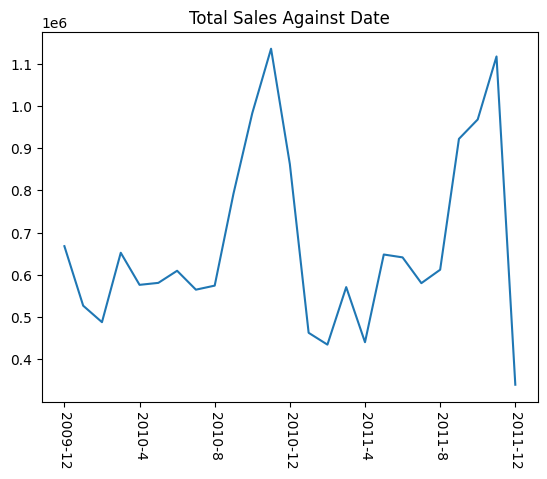

In [56]:
tmp = df.groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.title("Total Sales Against Date")
plt.xticks(rotation=-90)
plt.xticks(ticks=range(0, len(date_index), 4), labels=date_index[::4])
plt.plot(date_index, tmp.values)
plt.show()

We can see that spikes appear in the four quater of 2010 and 2011. The spikes maybe due to huge event or holiday like holloween or christmas. <br>
Next, let take a look at the popular products in fourth quarter

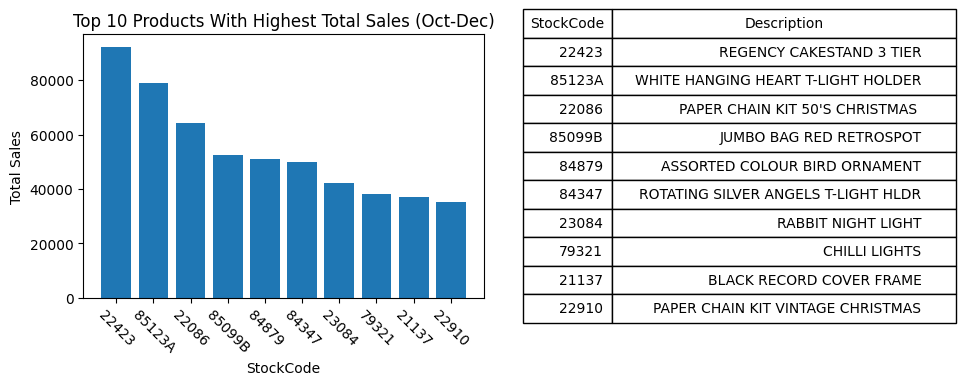

In [72]:
summary = df[df['Month']>=10].groupby('StockCode')['TotalPrice'].sum().sort_values(ascending=False).reset_index()
summary.rename(columns={'TotalPrice':'Total Sales'}, inplace=True)
tmp1 = df.groupby('StockCode')['Price'].idxmax().values
summary = pd.merge(summary, df[['StockCode', 'Description']].loc[tmp1], on='StockCode')
plot_top10_with_description(summary,'StockCode' , 'Total Sales', 'Total Sales', 'Top 10 Products With Highest Total Sales (Oct-Dec)')

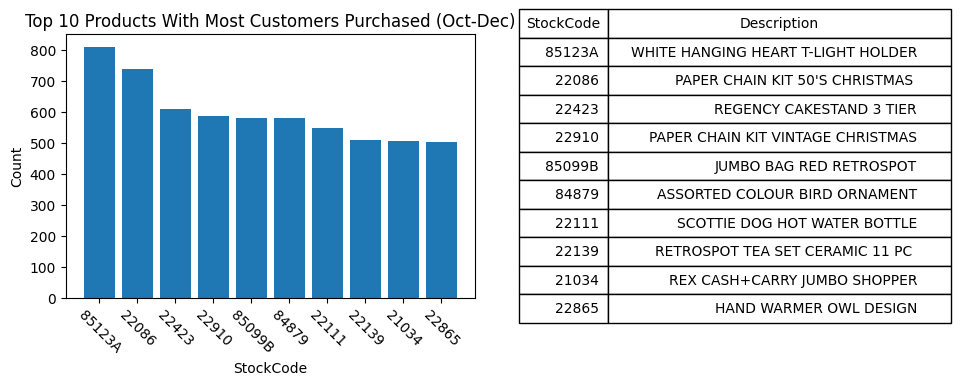

In [71]:
summary = df[df['Month']>=10].groupby(['StockCode', 'Customer ID'])['Quantity'].count().reset_index()
summary = summary.groupby('StockCode')['Customer ID'].count().sort_values(ascending=False).reset_index()
summary.rename(columns={'Customer ID':'# of Customers Purchased'}, inplace=True)
tmp1 = df.groupby('StockCode')['Price'].idxmax().values
summary = pd.merge(summary, df[['StockCode', 'Description']].loc[tmp1], on='StockCode')
plot_top10_with_description(summary,'StockCode' , '# of Customers Purchased', 'Count', 'Top 10 Products With Most Customers Purchased (Oct-Dec)')

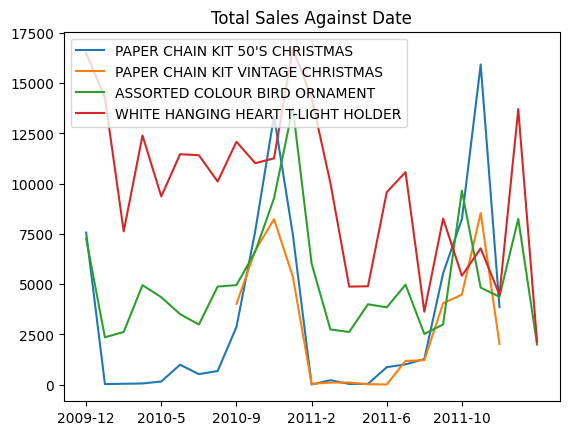

In [95]:
tmp = df[df['StockCode']=='22086'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.xticks(ticks=range(0, len(date_index), 4), labels=date_index[::4])
plt.plot(date_index, tmp.values, label=summary[summary['StockCode']=='22086']['Description'])
tmp = df[df['StockCode']=='22910'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.plot(date_index, tmp.values, label=summary[summary['StockCode']=='22910']['Description'])

tmp = df[df['StockCode']=='84879'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.plot(tmp.values, label=summary[summary['StockCode']=='84879']['Description'])

tmp = df[df['StockCode']=='85123A'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()

plt.plot(tmp.values, label=summary[summary['StockCode']=='85123A']['Description'])
plt.legend(loc='upper left')
plt.title("Total Sales Against Date")
plt.show()

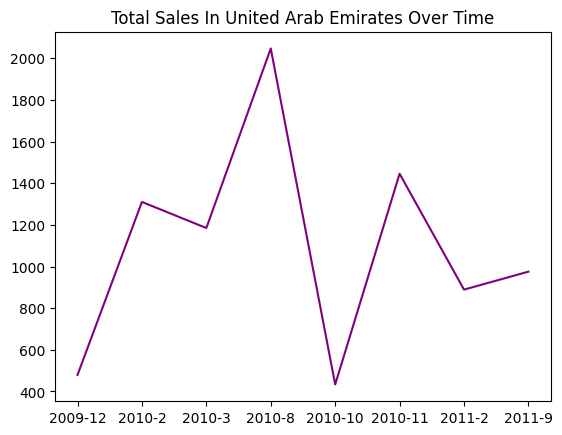

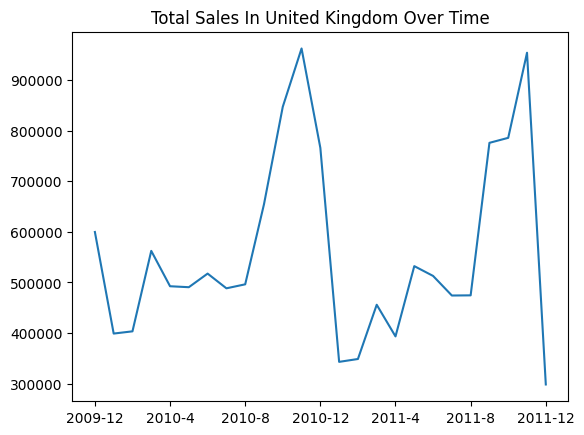

In [117]:
tmp = df[df['Country']=='United Arab Emirates'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.title("Total Sales In United Arab Emirates Over Time")
plt.plot(date_index, tmp.values, color='purple')
plt.show()
tmp = df[df['Country']=='United Kingdom'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.xticks(ticks=range(0, len(date_index), 4), labels=date_index[::4])
plt.title("Total Sales In United Kingdom Over Time")
plt.plot(date_index, tmp.values)
plt.show()

#### Summary

Here's a summary of the discoveries:
1. Customers are most likely to buy cheaper things than more expensive things
2. There exist some extreme cases which the transaction values are way larger than the average
3. Customers have decent chances to buy the same items again
4. Customers tend to buy products of similar prices in the same invoice
5. Customers will buy variances of items


## Prediction

In this section, we will build a model to predict the preference of customers. <br>
An user-base collaborative filtering model would be implemented. <br><br>

Cosine similarity is used to choose top 3 close-customers.

Before we start, let's preview the dataset that we have.

In [68]:
print(f"Number of records: {len(df)}")
print(f"Unique customers: {len(set(df['Customer ID'].unique()))}")
print(f"Unique products: {len(set(df['StockCode'].unique()))}")

Number of records: 794299
Unique customers: 5835
Unique products: 4608


Next, we transform the 'Customer ID' and 'StockCode' columns to number for the sake of easier computations.

In [69]:
label_customer = preprocessing.LabelEncoder()
label_customer.fit(df['Customer ID'])
df['Customer ID'] = label_customer.transform(df['Customer ID'])
label_product = preprocessing.LabelEncoder()
label_product.fit(df['StockCode'])
df['StockCode'] = label_product.transform(df['StockCode'])

Split the dataframe into train and test parts and feed to train data into the transaction matrix.

In [70]:
n_customer = len(df['Customer ID'].unique())
n_stockcode = len(df['StockCode'].unique())

In [71]:
train, test = train_test_split(df, test_size=0.2, random_state=1234)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

###### Collapse

In [72]:
transaction_matrix  = np.zeros((n_customer, n_stockcode))
for i in tqdm(range(len(train)), desc="Processing"):
    transaction_matrix[int(train.loc[i]['Customer ID']), int(train.loc[i]['StockCode'])] = 1

Processing:   0%|          | 0/635439 [00:00<?, ?it/s]

In [73]:
customers_matrix  = np.ones((n_customer, n_customer))*1e-4                 # prevent divide by 0
customers_length = np.sqrt(np.sum(transaction_matrix**2, axis=1))
for i in tqdm(range(n_customer), desc="Processing"):
    customers_matrix[i,:] = transaction_matrix.dot(transaction_matrix[i])/customers_length/np.sqrt(transaction_matrix[i].dot(transaction_matrix[i]))
for i in tqdm(range(n_customer), desc="Processing"):
    customers_matrix[i, i] = -1

Processing:   0%|          | 0/5835 [00:00<?, ?it/s]

C:\Users\marco\AppData\Local\Temp\ipykernel_31704\505451029.py:4: RuntimeWarning: invalid value encountered in divide
  customers_matrix[i,:] = transaction_matrix.dot(transaction_matrix[i])/customers_length/np.sqrt(transaction_matrix[i].dot(transaction_matrix[i]))


Processing:   0%|          | 0/5835 [00:00<?, ?it/s]

In [74]:
prediction_matrix = transaction_matrix*-1
for cid in tqdm(range(n_customer)):
    for close_cid in pd.Series(customers_matrix[cid]).sort_values(ascending=False).index[:3]:
        prediction_matrix[cid] += transaction_matrix[close_cid]-transaction_matrix[cid]

  0%|          | 0/5835 [00:00<?, ?it/s]

In [75]:
test['Prediction'] = test.apply(lambda x: prediction_matrix[x['Customer ID'], x['StockCode']], axis=1)
test['Prediction'] = test['Prediction'].map({3:'a3', 2:'a2', 1:'a1', 0:'N', -1:'A', -2:'b1', -3:'b2', -4:'b3'})

######

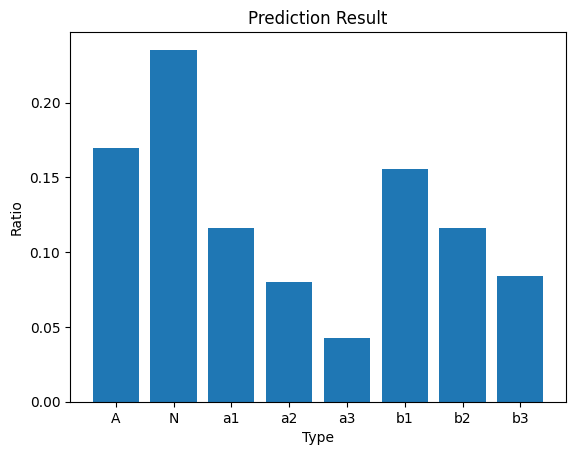

In [76]:
tmp = test.groupby('Prediction')['Customer ID'].count()
plt.bar(x=tmp.index, height=tmp.values/tmp.sum())
plt.title('Prediction Result')
plt.ylabel('Ratio')
plt.xlabel('Type')
plt.show()

Here's an explanation to the types, the customers have bought the items in the test set, <br>
given that in the train set,
- A : The customer and all of his close-customers bought the product
- N : Neither the customer nor his close-customers bought
- a(n) : The customer haven't bought the product, but (n) of his close-customers had done so
- b(n) : The customer have bought the product, but (n) of his close-customers hadn't done so

In [77]:
print(f"(a1~3)/(a1~3 + N) = {round(tmp[['a1', 'a2', 'a3']].sum()/tmp[['a1', 'a2', 'a3', 'N']].sum()*100, 2)}%")

(a1~3)/(a1~3 + N) = 50.39%


N and a1~3 are types that would be considered when recommending products to customers. <br>
A and b1~3 are types which the customers have already bought the items. <br><br>
a1~3 are the types that would be recommended to customers (ignore b1~3 and A for this moment), <br> 
if consider a1~3 and N only, they add up to ~50%, <br>
indicating that the recommended items would be bought in 50% of time, which sounds not good. <br>
however, in the EDA part, we calculated that a customer bought ~82 different products on average, <br>
meanwhile there are 4600+ products in the dataset. <br>
50% is actually quite good.


Now we have the whole dataset involved:

###### Collapse

In [78]:
transaction_matrix  = np.zeros((n_customer, n_stockcode))
for i in tqdm(range(len(df)), desc="Processing"):
    transaction_matrix[int(df.loc[i]['Customer ID']), int(df.loc[i]['StockCode'])] = 1

Processing:   0%|          | 0/794299 [00:00<?, ?it/s]

In [79]:
customers_matrix  = np.ones((n_customer, n_customer))*1e-4                 # prevent divide by 0
customers_length = np.sqrt(np.sum(transaction_matrix**2, axis=1))
for i in tqdm(range(n_customer), desc="Processing"):
    customers_matrix[i,:] = transaction_matrix.dot(transaction_matrix[i])/customers_length/np.sqrt(transaction_matrix[i].dot(transaction_matrix[i]))
for i in tqdm(range(n_customer), desc="Processing"):
    customers_matrix[i, i] = -1

Processing:   0%|          | 0/5835 [00:00<?, ?it/s]

Processing:   0%|          | 0/5835 [00:00<?, ?it/s]

In [80]:
prediction_matrix = transaction_matrix*-1
for cid in tqdm(range(n_customer)):
    for close_cid in pd.Series(customers_matrix[cid]).sort_values(ascending=False).index[:3]:
        prediction_matrix[cid] += transaction_matrix[close_cid]-transaction_matrix[cid]

  0%|          | 0/5835 [00:00<?, ?it/s]

In [81]:
tmp2 = df.apply(lambda x: prediction_matrix[x['Customer ID'], x['StockCode']], axis=1)
tmp2 = tmp2.map({3:'a3', 2:'a2', 1:'a1', 0:'N', -1:'A', -2:'b1', -3:'b2', -4:'b3'})

######

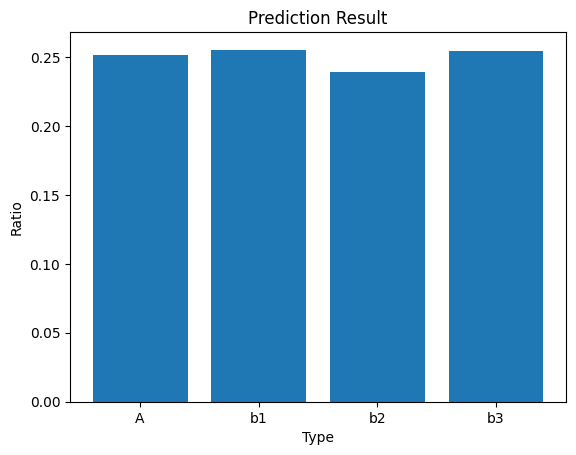

In [82]:
tmp = tmp2.groupby(by=tmp2.values).count()
plt.bar(x=tmp.index, height=tmp.values/tmp.sum())
plt.title('Prediction Result')
plt.ylabel('Ratio')
plt.xlabel('Type')
plt.show()

Here's an explanation to the types, in the dataset,
- A : The customer and all of his close-customers bought the product
- b(n) : The customer have bought the product, but (n) of his close-customers hadn't done so

The ratio of each type is quite balanced. <br>
for ~75% (1-b3) of time, the items which are bought by customers can also be found in their close-customers' records, <br>
indicating strong correlations between customers' preferences.




## Future Enhancement

1. This project focused on the Customer ID and StockCode. The Country and Date Columns could also be utilized to build more sophisticated models.
2. An item-base collaborative filtering model can be used to better analyse the relationships between different products.